In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self,data,_children=(),_op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)

        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __neg__(self):
        return self * -1
    def __sub__(self,other):
        return self + (-other)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad += out.grad * self.data**(other-1) * other
        
        out._backward = _backward
        return out
    def __truediv__(self,other):
        return self*other**-1
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out


    


    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += out.grad * (1-t**2)
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label = 'e'

d = e+c; d.label = 'd'
f = Value(-2.0,label='f')
L = d*f; L.label = 'L'

In [5]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid,label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid+ n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

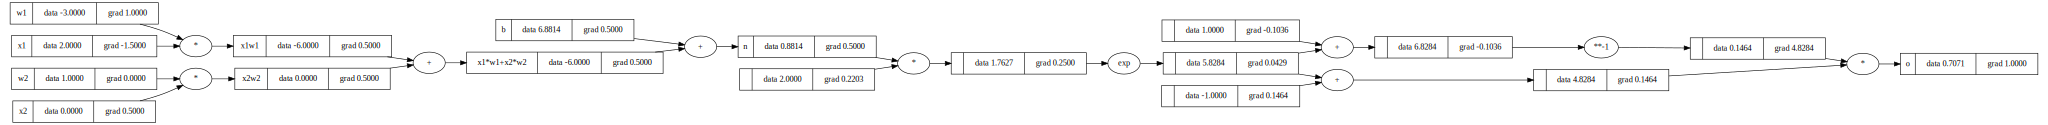

In [32]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.88137,label='b')

x1w1 = x1*w1;x1w1.label='x1w1'
x2w2 = x2*w2;x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n=x1w1x2w2 + b;n.label='n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [7]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o=torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())


0.7070699720278941
---
x2 0.5000520546564731
w2 0.0
x1 -1.5001561639694192
w1 1.0001041093129461


In [10]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [15]:
import random

In [29]:
from typing import Any


class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
        out = act.tanh()
        return out
    
class Layer():
    def __init__(self,nin,nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x) -> Any:
        outs = [n(x) for n in self.neurons]
        return outs
    
class MLP:
    def __init__(self,nin,nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x) -> Any:
        for layer in self.layers:
            x = layer(x)
        return x
x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

[Value(data=-0.34284303788695525)]

In [31]:
draw_dot(n(x))

TypeError: unhashable type: 'list'